Import libraries and set some parameters for the Data and Gaussian Filter. Creating a 1 kHz signal, getting 8 symbols. Gaussian filter will have a 3-db bandwidth of 0.5 * 1 kHz. Trying different combinations of sampling rates and gaussian filter spans.

In [1]:
%matplotlib inline
from pylab import *
import matplotlib.figure
import scipy.signal
import itertools
import mpld3
mpld3.enable_notebook()

#set plot size and resolution
rcParams['figure.figsize'] = 10, 6
rcParams['figure.dpi'] = 90

#Play around with these values
frequency = 1e3
BT = 0.5
num_symbols = 8
gauss_spans = [2, 3]
gauss_sample_rates = [4, 5, 6]

gauss_params = list(itertools.product(gauss_spans, gauss_sample_rates)) #each elem is of form (span, sample rate)

Creating gaussian impulses based on the parameters specified above. Gaussian impulses are normalized.

The impulses are then plotted in the time domain.

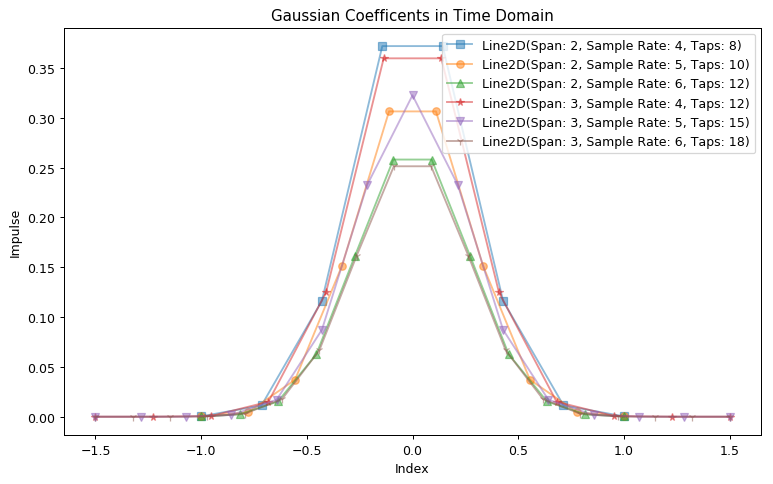

In [2]:
def gauss_imp(BT, frequency, span, sample_rate):
    #num_coefficients is the sampling rate of the filter
    #3db_bandwidth is the 3db bandwidth of the gaussian filter
    #symbol time is the time difference between two symbols during transmission
    alph = np.sqrt(2. * np.pi / np.log(2)) * BT
    imp = np.linspace(- span * sample_rate / 2, span * sample_rate / 2, span*sample_rate)
    #generate coefficents
    imp *= np.sqrt(np.pi) * alph / sample_rate
    imp = - np.power(imp, 2)
    imp = np.exp(imp)
    imp *= alph
    imp /= sum(imp)
    return imp

impulses = [gauss_imp(BT, frequency, p[0], p[1]) for p in gauss_params]

#Plotting Time Domain
plt.figure()
time_x = [np.linspace(- p[0] * p[1] / 2, p[0] * p[1] / 2, p[0] * p[1]) / p[1] for p in gauss_params]
legend = []
markers = ['s', 'o', '^', '*', 'v', '1', '2', '3', 'p', '+', 'x', 'X', 'd', 'D']
for i in range(len(gauss_params)):
    span = gauss_params[i][0]
    sample_rate = gauss_params[i][1]
    num_taps = span * sample_rate
    lg, = plt.plot(time_x[i], impulses[i], 
                     alpha = 0.5,
                     marker = markers[i],
                   label='Span: {}, Sample Rate: {}, Taps: {}'.format(span, sample_rate, num_taps))
    legend.append(lg)
plt.title('Gaussian Coefficents in Time Domain')
plt.xlabel('Index')
plt.ylabel('Impulse')lo
plt.legend(legend)
plt.show();

The FFT of the coefficients is plotted, with the amplitudes in units of decibels.

/Users/garychen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


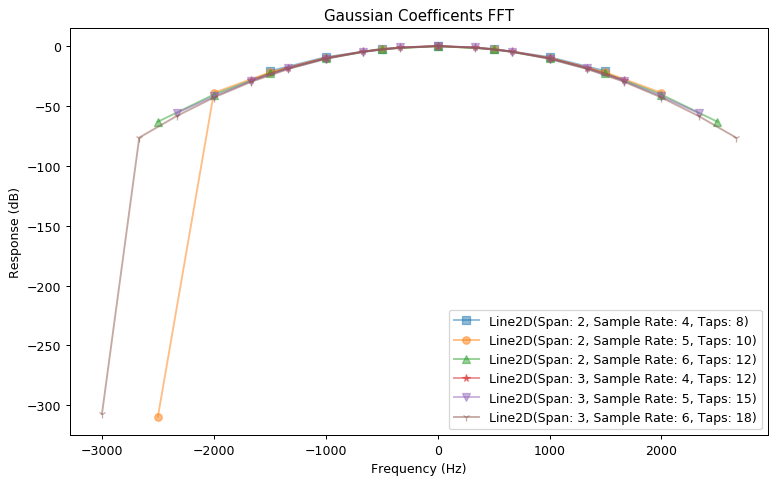

In [3]:
#Plotting FFT
plt.figure()
filter_ffts = [] 
filter_fft_dbs = []
#Generate FFT of the coefficients
for imp in impulses:
    filter_ffts.append(np.abs(np.fft.fftshift(np.fft.fft(imp)))) #FFT of filter
    filter_fft_dbs.append(20 * np.log10(filter_ffts[-1]))

#Get x-axis in units of multiples of the signal frequency
fft_x = [sorted(np.fft.fftfreq(len(filter_ffts[i]), 1./gauss_params[i][1]) * frequency) for i in range(len(gauss_params))]

for i in range(len(gauss_params)):
    span = gauss_params[i][0]
    sample_rate = gauss_params[i][1]
    num_taps = span * sample_rate
    lg, = plt.plot(fft_x[i], filter_fft_dbs[i], 
                     alpha = 0.5,
                     marker = markers[i],
                   label='Span: {}, Sample Rate: {}, Taps: {}'.format(span, sample_rate, num_taps))
    legend.append(lg)
plt.title('Gaussian Coefficents FFT')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Response (dB)')
plt.legend(legend)
plt.show();

A close-up of the 3db range of the filters is plotted.

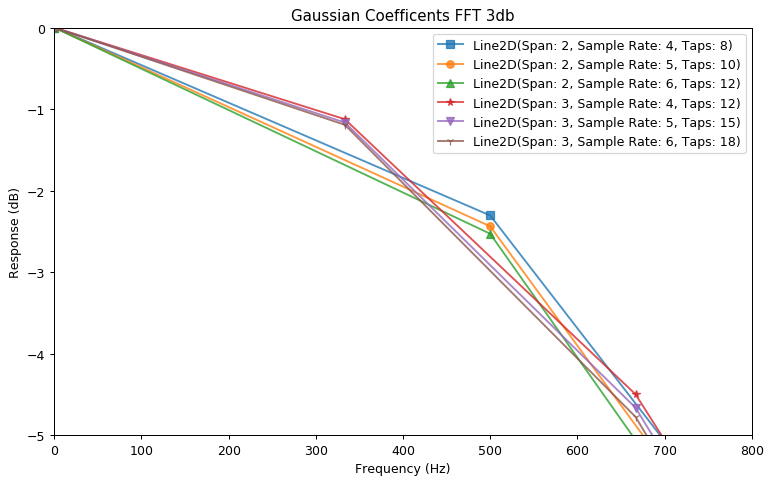

In [4]:
#Plot FFT zoomed in on the 3-db bandwidth 
plt.figure()
axes = plt.gca()
axes.set_ylim([-5, 0])
axes.set_xlim([0, 0.8 * frequency])
for i in range(len(gauss_params)):
    span = gauss_params[i][0]
    sample_rate = gauss_params[i][1]
    num_taps = span * sample_rate
    lg, = plt.plot(fft_x[i], filter_fft_dbs[i], 
                     alpha = 0.8,
                     marker = markers[i],
                   label='Span: {}, Sample Rate: {}, Taps: {}'.format(span, sample_rate, num_taps))
    legend.append(lg)
plt.title('Gaussian Coefficents FFT 3db')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Response (dB)')
plt.legend(legend)
plt.show();

Next, periodic square wave data is generated and then convolved with the Gaussian Filters. The results are plotted in the time domain.

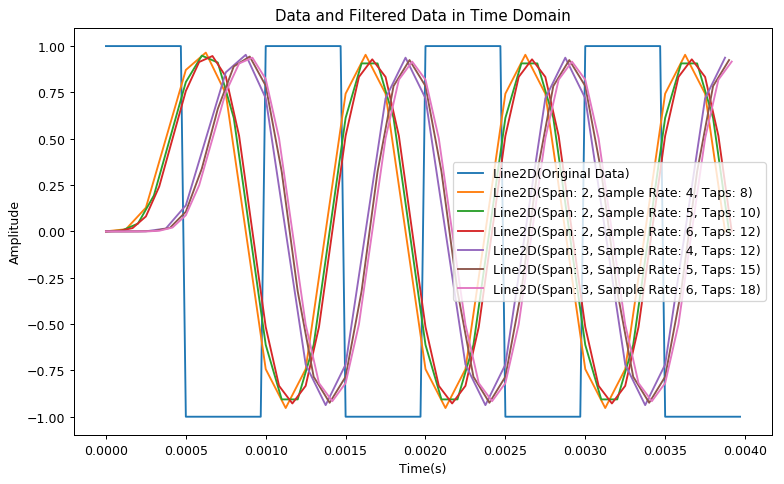

In [5]:
def generate_periodic_data(num_symbols, num_samples, frequency):
    return scipy.signal.square(
          np.linspace(0, num_symbols * num_samples/(2 * frequency * num_samples),
                      num_symbols * num_samples, endpoint=False)
          * 2 * np.pi * frequency)

import random
#Generate random square wave
def random_square_wave(num_symbols, num_samples):
    arr = []
    for i in range(num_symbols):
        symb = random.randint(0, 1)
        for j in range(num_samples):
            arr.append(symb)
    return np.array(arr)

def convolve(data, imp):
    out = []
    for a in range(len(data)):
        count = 0
        for i in range(len(imp)):
            if a - i >= 0:
                count += imp[i] * data[a - i]
        out.append(count)
    return np.array(out)

#For plotting original points
orig_sample_rate = 16
orig = generate_periodic_data(num_symbols, orig_sample_rate, frequency)

#Filtering data
filtered = []
for i in range(len(gauss_params)):   
    data = generate_periodic_data(num_symbols, gauss_params[i][1], frequency)
    filtered.append(convolve(data, impulses[i]))
    
#Plotting
plt.figure()
orig_axis = np.arange(len(orig)) / (2.0 * frequency * orig_sample_rate)

orig_lg, = plt.plot(orig_axis, orig, label='Original Data')
legend = [orig_lg]
for i in range(len(gauss_params)):
    span = gauss_params[i][0]
    sample_rate = gauss_params[i][1]
    num_taps = span * sample_rate
    x_axis = np.arange(len(filtered[i])) / (2.0 * frequency * sample_rate)
    
    lg, = plt.plot(x_axis, filtered[i], label='Span: {}, Sample Rate: {}, Taps: {}'.format(span, sample_rate, num_taps))
    legend.append(lg)
    
plt.title('Data and Filtered Data in Time Domain')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')
plt.legend(legend)

plt.show()

The frequency responses of the original and filtered data are plotted. Note that the frequency amplitudes of the original data are not scaled correctly to the amplitudes of the filtered data since the sampling rates are different. 

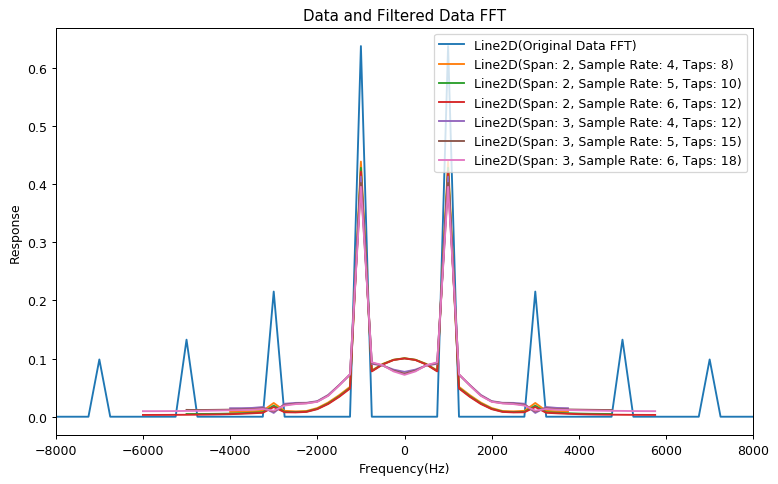

In [6]:
#Original Data FFT
orig_fft = np.abs(np.fft.fftshift(np.fft.fft(orig)))
orig_fft /= len(orig)
orig_freq = sorted(np.fft.fftfreq(len(orig), 1/(2.0 * orig_sample_rate * frequency)))

#Get FFT of data and frequency responses
filtered_fft = []
filtered_freq = []
for i in range(len(gauss_params)):
    filtered_fft.append(np.abs(np.fft.fftshift(np.fft.fft(filtered[i])))/len(filtered[i]))
    filtered_freq.append(sorted(np.fft.fftfreq(len(filtered_fft[-1]), 1/(2.0 * gauss_params[i][1] * frequency))))

#Plotting
plt.figure()
orig_fft_lg, = plt.plot(orig_freq, orig_fft, label = 'Original Data FFT')
legend = [orig_fft_lg]

for i in range(len(gauss_params)):
    span = gauss_params[i][0]
    sample_rate = gauss_params[i][1]
    num_taps = span * sample_rate
    lg, = plt.plot(filtered_freq[i], filtered_fft[i],
                   label='Span: {}, Sample Rate: {}, Taps: {}'.format(span, sample_rate, num_taps))
    legend.append(lg)

plt.legend(legend)
plt.xlabel('Frequency(Hz)')
plt.ylabel('Response')
plt.title('Data and Filtered Data FFT')

axes = plt.gca()
axes.set_xlim([-8 * frequency, 8 * frequency])
plt.show()

Convert Impulse to Fixed point bit representation

In [96]:
import struct

#Get bit representation of floats (IEEE Format)
def floatToBits(f):
    s = struct.pack('>f', f)
    return struct.unpack('>l', s)[0]

#Convert floats to 16 bit fixed point (0x_ _ _ _)
def convert_float_to_fixed(arr, res):
    fixed_imp = []
    for coeff in arr.astype('float32'):
        if coeff > 0:
            bits = floatToBits(coeff.item())
            mantissa =  (bits & 0x7FFFFF) + 0x800000
            mantissa = mantissa << 8
            exp = ((bits & 0x7F800000) >> 23) - 127
            if exp > 0:
                num = "0x{:08x}".format(mantissa << exp)
            else:
                num = "0x{:08x}".format(mantissa >> -exp)
            num = num[:-4]
            fixed_imp.append(num)
    return fixed_imp

test_imp = gauss_imp(0.5, 1000, 2, 8)

print(convert_float_to_fixed(test_imp, 5))

['0x0005', '0x001f', '0x008e', '0x01fa', '0x0573', '0x0ba6', '0x1353', '0x18e4', '0x18e4', '0x1353', '0x0ba6', '0x0573', '0x01fa', '0x008e', '0x001f', '0x0005']
